In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import crystalball
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)
print("pandas version", pd.__version__)
#print("scipy.optimize version", scipy.optimize.__version__)
#print("scipy.integrate version", scipy.integrate.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1
pandas version 1.5.3


In [2]:
X = [1.5174999999999998, 1.5525, 1.5875, 1.6225, 1.6574999999999998, 1.6925, 1.7275, 1.7625000000000002, 
     1.7975, 1.8325, 1.8675000000000002, 1.9025000000000003, 1.9375, 1.9725, 2.0075, 2.0425, 2.0775, 2.1125, 
     2.1475, 2.1825, 2.2175000000000002, 2.2525, 2.2875, 2.3225, 2.3575, 2.3925, 2.4275, 2.4625, 2.4975, 
     2.5324999999999998, 2.5675, 2.6025, 2.6375, 2.6725000000000003, 2.7075, 2.7424999999999997, 2.7775, 
     2.8125, 2.8475, 2.8825000000000003, 2.9175000000000004, 2.9524999999999997, 2.9875, 3.0225, 3.0575, 
     3.0925, 3.1275, 3.1625, 3.1975, 3.2325, 3.2675, 3.3025, 3.3375, 3.3725000000000005, 3.4074999999999998, 
     3.4425000000000003, 3.4775, 3.5125, 3.5475, 3.5824999999999996, 3.6174999999999997, 3.6525000000000003, 
     3.6875, 3.7224999999999997, 3.7575000000000003, 3.7925000000000004, 3.8275, 3.8625, 3.8975, 
     3.9324999999999997, 3.9675, 4.0024999999999995, 4.0375, 4.0725, 4.1075, 4.1425, 4.1775, 4.2125, 
     4.2475000000000005, 4.2825, 4.3175, 4.352499999999999, 4.3875, 4.422499999999999, 4.4575, 
     4.492500000000001, 4.5275, 4.5625, 4.5975, 4.632499999999999, 4.6675, 4.702500000000001, 4.7375, 
     4.772500000000001, 4.8075, 4.842499999999999, 4.8775, 4.9125, 4.9475, 4.9825]

Y_1 = [36675.0, 33971.0, 31674.0, 29679.0, 27416.0, 25215.0, 23659.0, 21985.0, 20087.0, 18943.0, 17778.0, 16429.0, 15087.0, 14345.0, 13408.0, 12229.0, 11187.0, 10586.0, 9989.0, 9179.0, 8867.0, 8150.0, 7491.0, 6904.0, 6441.0, 6098.0, 5658.0, 5384.0, 4973.0, 4727.0, 4356.0, 4148.0, 3855.0, 3671.0, 3476.0, 3245.0, 3123.0, 3026.0, 2983.0, 3053.0, 3249.0, 3432.0, 4073.0, 5292.0, 6468.0, 7349.0, 6865.0, 5031.0, 3139.0, 2031.0, 1422.0, 1164.0, 1059.0, 930.0, 897.0, 784.0, 849.0, 766.0, 721.0, 742.0, 674.0, 692.0, 661.0, 645.0, 564.0, 518.0, 457.0, 413.0, 411.0, 403.0, 386.0, 384.0, 359.0, 317.0, 319.0, 299.0, 277.0, 248.0, 262.0, 238.0, 199.0, 244.0, 231.0, 203.0, 212.0, 205.0, 181.0, 181.0, 165.0, 164.0, 151.0, 154.0, 142.0, 138.0, 127.0, 130.0, 123.0, 113.0, 105.0, 117.0]

vMass_OS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name='$m_{\mu \mu}$', label = 'X'))
vMass_OS.fill(X, weight = Y_1)

Hist(Regular(100, 1.5, 5, name='$m_{\\mu \\mu}$', label='X'), storage=Double()) # Sum: 567225.0

In [3]:
def funcVec(x, N, mu, sig, alphaL, nL, alphaR, nR):
    AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
    AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
    BL = nL / np.absolute( alphaL ) - np.absolute( alphaL )
    BR = nR / np.absolute( alphaR ) - np.absolute( alphaR )

    return np.piecewise(x, 
                        [( x - mu )/sig < -1 * alphaL, (( x - mu )/sig >= -1 * alphaL) & (( x - mu )/sig <= alphaR).any() , ( x - mu )/sig > alphaR],
                        [lambda x: N * AL * (BL - (( x - mu )/sig))**(-nL), lambda x: N * np.exp(-1 * (( x - mu )/sig)**2 / 2), lambda x: N * AR * (BR + ( x - mu )/sig)**(-nR)])

def NA60(x, N, mu, sig, alphaL, p1L, p2L, p3L, alphaR, p1R, p2R, p3R):
    return np.piecewise(x, 
                        [(x - mu)/sig < alphaL, 
                         ((x - mu)/sig >= alphaL) & ((x - mu)/sig <= alphaR).any() , 
                         (x - mu)/sig > alphaR],
                        [lambda x: N * np.exp(-0.5 * ((x - mu)/sig)**2 / (1 + p1L * (alphaL - (x - mu)/sig)**(p2L - p3L * np.sqrt(alphaL - (x - mu)/sig)))**2), 
                         lambda x: N * np.exp(-0.5 * ((x - mu)/sig)**2), 
                         lambda x: N * np.exp(-0.5 * ((x - mu)/sig)**2 / (1 + p1R * (alphaR - (x - mu)/sig)**(p2R - p3R * np.sqrt(alphaR - (x - mu)/sig)))**2)])

def VWG(x, N, mu, alpha, beta):
    sigma = alpha + beta*((x-mu)/mu)
    return N * np.exp(-(x - mu)**2 / (2*sigma**2))

def PR(x, N, a1, b1, b2):
    return N * (1 + a1*x) / (b1*x + b2*x)

def DE(x, N, alpha, beta1, beta2):
    return N * (np.exp(beta1*x) + alpha * np.exp(beta2*x))

def DE2(x, N, alpha, gamma, beta1, beta2, beta3):
    return N * (np.exp(beta1*x) + alpha * np.exp(beta2*x) + gamma * np.exp(beta3*x))

def fitFunc2(x,
            N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1,
            N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2,
            N, alpha, gamma, beta1, beta2, beta3):
    return funcVec(x, N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1) + funcVec(x, N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2) + DE2(x, N, alpha, gamma, beta1, beta2, beta3)

def fitFunc(x,
            N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1,
            N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2,
            Nbg, a1, a2, a3):
    return funcVec(x, N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1) + funcVec(x, N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2) + DE(x, Nbg, a1, a2, a3)

In [4]:
#eps = np.finfo(np.float64).eps
#eps = 0.1

x_data = np.array(X)
y_data = np.array(vMass_OS)
#y_error = np.array(np.sqrt(y_data)) + eps
y_error = np.array(np.sqrt(y_data))

condition = (x_data > 1.9)
#condition = True
x_filtered = np.ravel(x_data[condition])
y_filtered = np.ravel(y_data[condition])
y_error_filtered = np.ravel(y_error[condition])

x_data = x_filtered
y_data = y_filtered
y_error = y_error_filtered

In [23]:
"""p0 = np.array([45495.82873270734, 3.0948049097469124, 0.07328444096670474, 0.9142455163363677, 
               4.7910964558157785, 1.7597126827730232, 9.732758608176749, 889.2674553435587, 
               3.678066385549034, 0.08553624671003622, 11.337526631014516, 146.73893885250723, 
               10.911572881818802, 163.29570256476117, 26989.081283882504, 49.639335099336854, 
               -0.4819663774691703, -1.6547090353845417])"""

p0 = np.array([5534.708099472125, 3.097527305201937, 0.06694515740769462, 0.858138445292884, 
               10.903566059719685, 18.19664848741087, 8.141235556827876, 96.200381228583, 
               3.6981686715671347, 0.05721810746263883, 1.0149071364897841, 22.324893743056005, 
               2.736747459908999, 1.805251184968137e-05, 3514.620666056445, 238.85659436275319, 
               -0.7642429951342202, -2.147342236312142])

def mklb(p0, var):
    return p0*(1-np.sign(p0)*var)

def mkub(p0, var):
    return p0*(1+np.sign(p0)*var)

varbg = np.ones(np.shape(p0[14:]))*1# bg parameters variation factor around p0
varpks = np.array([10, 0.05, 0.05, *0.1*np.ones(4)])  # peaks parameters variation factor around p0
lb = np.array([*mklb(p0[0:7],varpks), *mklb(p0[7:14],varpks), *mklb(p0[14:],varbg)])
ub = np.array([*mkub(p0[0:7],varpks), *mkub(p0[7:14],varpks), *mkub(p0[14:],varbg)])
bounds = (lb,ub)

In [24]:
#popt, pcov, nfev, fvec, fjac = curve_fit(fitFunc, xdata = x_data, ydata = y_data, sigma = y_error, method = 'trf', full_output = True)
#popt, pcov, nfev, fvec, fjac = curve_fit(fitFunc, xdata = x_data, ydata = y_data, sigma = y_error, p0 = p0, method = 'trf', full_output = True)
popt, pcov, nfev, fvec, fjac = curve_fit(fitFunc, xdata = x_data, ydata = y_data, sigma = y_error, p0 = p0, bounds = bounds, method = 'trf', full_output = True)

print("popt: \n", list(popt)) 
print("pcov: \n", pcov)
print("residual: \n", nfev)

popt: 
 [5813.6534402966245, 3.0969493931054806, 0.0673048445101242, 0.8306464316973259, 9.85712944348349, 20.01105229536182, 7.6260679609544955, 102.82967954678962, 3.694412151555921, 0.05855656883306327, 1.0524025199520592, 24.525754699862333, 2.469291554735258, 1.628793301764922e-05, 3005.910650194614, 284.43337499235446, -0.7232769791696421, -2.1046279814053688]
pcov: 
 [[ 3.85470505e+03  8.55164885e-03 -2.27616051e-02  2.42414446e-01
  -9.28526840e+01 -1.48283724e-07  2.24610292e-07  1.16799743e+02
  -6.51947918e-02  9.97949120e-02  1.42912682e+01 -1.87383908e+04
  -1.08340412e+02  2.30439380e+01 -6.06874145e+04  5.62539941e+03
   4.59215401e+00  5.16783151e-01]
 [ 8.55164885e-03  1.25736578e-06 -8.34153125e-07 -4.27633594e-05
   3.65754490e-03  1.53336399e-12 -2.25643010e-12 -6.17166978e-04
   5.99476432e-07 -2.21081384e-07 -7.91182279e-05  1.37374425e-01
   1.07505032e-03 -2.50100494e-04  6.37524274e-01 -6.06114514e-02
  -5.18155073e-05 -2.55702610e-06]
 [-2.27616051e-02 -8.3415

fit error : 8492.621010735338


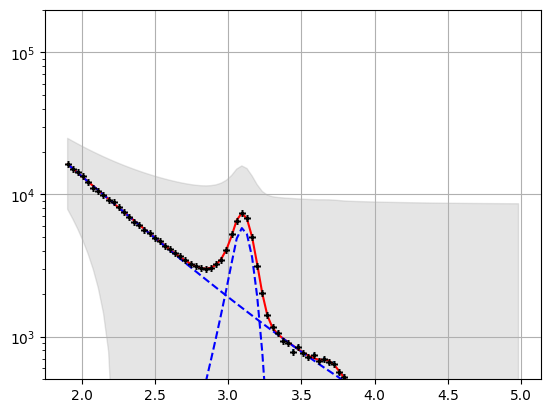

In [25]:
x_data_fit = np.linspace(min(x_data), max(x_data), len(x_data))
plt.errorbar(x_data, y_data, y_error, marker='+', mfc='black', mec='black', ms=2, mew=5, ls='')

y_data_fit = fitFunc(x_data_fit, *popt)
plt.plot(x_data_fit, y_data_fit, '-r')
plt.plot(x_data_fit, funcVec(x_data_fit, *popt[:7]), '--b')
plt.plot(x_data_fit, funcVec(x_data_fit, *popt[7:14]), '--b')
plt.plot(x_data_fit, DE(x_data_fit, *popt[14:18]), '--b')
plt.yscale('log')
plt.ylim(500, 200000)
plt.grid(True)

sigmas = np.diag(pcov)
e_data_fit = np.sqrt(np.sum(sigmas))
print("fit error :", e_data_fit)

plt.fill_between(x_data_fit, y_data_fit - e_data_fit, y_data_fit + e_data_fit, color = 'gray', alpha = 0.2)

In [26]:
print(quad(funcVec, 0, np.inf, args = (*popt[:7], )))

(1152.9091011456323, 2.1966456415097556e-06)


In [27]:
mu_JPsi = popt[1]
sigma_JPsi = popt[2]
start = mu_JPsi - 3*sigma_JPsi
stop = mu_JPsi + 3*sigma_JPsi
signal_JPsi = quad(funcVec, start, stop, args = (*popt[:7], ))[0]
bruit = quad(DE, start, stop, args = (*popt[14:], ))[0]
print("Signal J/Psi:", signal_JPsi)
print("Bruit :", bruit)
print("RSB J/Psi:", signal_JPsi / np.sqrt(signal_JPsi + bruit))
print("RSB J/Psi:", signal_JPsi / bruit)

mu_Psi  = popt[8]
sigma_Psi = popt[9]
start = mu_Psi  - 3*sigma_Psi
stop = mu_Psi  + 3*sigma_Psi
signal_Psi = quad(funcVec, start, stop, args = (*popt[7:14], ))[0]
bruit = quad(DE, start, stop, args = (*popt[14:], ))[0]
print("\nSignal Psi(2S):", signal_Psi)
print("Bruit :", bruit)
print("RSB Psi(2S):", signal_Psi / np.sqrt(signal_Psi + bruit))
print("RSB Psi(2S):", signal_Psi / bruit)

Signal J/Psi: 1067.6590245344014
Bruit : 655.0426872646227
RSB J/Psi: 25.723350343239474
RSB J/Psi: 1.6299075545638309

Signal Psi(2S): 15.843914613659312
Bruit : 202.22458941155836
RSB Psi(2S): 1.072916739362479
RSB Psi(2S): 0.07834811117561225


In [28]:
perr = np.sqrt(np.diag(pcov))

In [29]:
r = y_data - fitFunc(x_data, *popt)
chi2 = sum((r / y_error) ** 2)
print(chi2)

85.73867720421846


In [30]:
ndf = len(x_data) + len(popt) - 1

In [31]:
chi2 / ndf

0.8088554453228157